In [17]:
import numpy as np
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt

In [2]:
def greedy_maximin(data, remaining, selected,  n, metric="euclidean"):
    """
        data: pandas dataframe(rows=points, cols=dimensions)
            points to choose from
            
        remaining: indexes of `data` that are candidates for the next point
        
        selected: indexes of `data` that have already been included
        
        n: number of additional points to include
        
        metric: "euclidean" "cityblock"
            distance measures from scipy.spatial.distance
    """
    distances = []
    for _ in range(n):
        dists = distance.cdist(data.loc[selected], data.loc[remaining], metric)
        closest = dists.min(axis=0)  # distance between candidates and closest selection
        distances.append(closest.max())
        add = remaining[np.argmax(closest)]
        selected += [add]
        remaining.remove(add)

    return selected, distances

In [3]:
def within_set_distance(data, selected, metric="euclidean"):
    return distance.cdist(data.loc[selected],data.loc[selected], metric) 

In [4]:
task_map = pd.read_csv("https://raw.githubusercontent.com/Watts-Lab/task-mapping/master/task_map.csv", index_col="task")

In [5]:
# drop things that we can't play
task_map.drop('Railroad Route Construction game (Impossible Version)', inplace = True)

In [6]:
scores_dict = {}
for task in task_map.index:
    selected = [task]
    remaining = list(task_map.index.difference(selected))
    choices,scores = greedy_maximin(task_map, remaining, selected, n=10)
    scores_dict[task] = scores[9]

scores_dict

{'Categorization problem': 1.2666853861623764,
 'Mastermind': 1.1359674317237467,
 'Logic Problem': 1.138013480692106,
 'Sudoku': 1.1815937548338622,
 'Rank cities by population, rank words by familiarity': 1.245662832693769,
 'Shopping plan': 1.2783177766403093,
 'Iterative lemonade stand task': 1.2492651678687603,
 'Reading the mind in the eyes': 1.245662832693769,
 'Writing story': 1.327927353825807,
 'Moral Reasoning (Disciplinary Action Case)': 1.327927353825807,
 'Word construction from a subset of letters': 1.327927353825807,
 'Carter Racing': 1.327927353825807,
 'Guessing the correlation': 1.245662832693769,
 'Wolf, goat and cabbage transfer': 1.327927353825807,
 'Room assignment task': 1.230500442813333,
 'Arithmetic problem 1': 1.2423124375329524,
 'Space Fortress': 1.1950364528599255,
 'Visual Oddball Target': 1.2852284292264256,
 'The N light bulbs game': 1.294694757035991,
 'Word completion given starting letter': 1.2956786507112639,
 'Railroad Route Construction game': 1.

In [7]:
print(np.quantile(list(scores_dict.values()), [0.5, 0.95]))

[1.26014956 1.32792735]


In [8]:
pd.Series(scores_dict).idxmax()

'Writing story'

In [9]:
selected = ['Writing story']
remaining = list(task_map.index.difference(selected))
choices,scores = greedy_maximin(task_map, remaining, selected, n=10)
choices

['Writing story',
 '9 Dot Problem',
 'Word construction from a subset of letters',
 'Image rating',
 'Checkers',
 'Run a mini business',
 'Typing game',
 'Whac-A-Mole',
 'Divergent Association Task',
 'Carter Racing',
 'Object based generalization for reasoning (Phyre)']

In [10]:
# print the scores
scores

[3.033024588462129,
 2.3611329688851113,
 2.023028412417927,
 1.7957277411343644,
 1.6941734671205697,
 1.651693174221916,
 1.4104539514341472,
 1.4049906884518972,
 1.3675509868542826,
 1.327927353825807]

In [11]:
def get_min_dist_within_set(selected):
    res = within_set_distance(task_map, selected)
    res[res == 0] = 10000000 # get rid of the diagonal, which is obviously zero
    return np.min(res)

In [12]:
selected = ['Euclidean traveling salesperson', 'Allocating resources to programs', '9 Dot Problem', 'Guessing the correlation', 'Abstract grid task', 'Advertisement writing', 'Whac-A-Mole', 'Putting food into categories', 'Room assignment task', 'Divergent Association Task', 'Recall association']
get_min_dist_within_set(selected)

0.5287476560780826

In [13]:
get_min_dist_within_set(choices)

1.327927353825807

In [14]:
# What happens if we started with room assignment as before?
selected = ['Room assignment task']
remaining = list(task_map.index.difference(selected))
print(greedy_maximin(task_map, remaining, selected, n=10)[0])
get_min_dist_within_set(greedy_maximin(task_map, remaining, selected, n=10)[0])

['Room assignment task', 'Summarize Discussion', 'Whac-A-Mole', '9 Dot Problem', 'Word construction from a subset of letters', 'Image rating', 'Putting food into categories', 'Typing game', 'Railroad Route Construction game', 'Run a mini business', 'Object based generalization for reasoning (Phyre)']


0.9814959426038877

## Which tasks should we replace to improve our score?
What if we start with our existing set, and greedily replace tasks with the one most likely to improve our score?

In [15]:
original_tasks = ('Euclidean traveling salesperson', 'Allocating resources to programs', '9 Dot Problem', 'Guessing the correlation', 'Abstract grid task', 'Advertisement writing', 'Whac-A-Mole', 'Putting food into categories', 'Room assignment task', 'Divergent Association Task', 'Recall association')

In [16]:
# set the max number of replacements you're willing to make
MAX_NUM_TASKS_TO_REPLACE = 20
dists_per_iteration = []

# start with existing set
current_task_list = original_tasks

for i in range(MAX_NUM_TASKS_TO_REPLACE):
    # go through each one and try replacing it to find the most optimal replacement
    optimal_replacements = {}

    for task in current_task_list:
        selected_minus_task = list(current_task_list)
        selected_minus_task.remove(task)
        remaining = list(task_map.index.difference(selected_minus_task))
        new_set = greedy_maximin(task_map, remaining, selected_minus_task, n=1)[0] # get a replacement'
        optimal_replacements[task] = get_min_dist_within_set(new_set)
    
    optimal_task_to_replace = pd.Series(optimal_replacements).idxmax()
    print(optimal_task_to_replace)
    
    # now set the task to the optimally-replaced one
    selected_minus_task = list(current_task_list)
    selected_minus_task.remove(optimal_task_to_replace)
    remaining = list(task_map.index.difference(selected_minus_task))
    current_task_list = (greedy_maximin(task_map, remaining, selected_minus_task, n=1)[0]) # get a replacement'
    print(current_task_list)
    print(get_min_dist_within_set(list(current_task_list)))
    dists_per_iteration.append(get_min_dist_within_set(list(current_task_list)))

Abstract grid task
['Euclidean traveling salesperson', 'Allocating resources to programs', '9 Dot Problem', 'Guessing the correlation', 'Advertisement writing', 'Whac-A-Mole', 'Putting food into categories', 'Room assignment task', 'Divergent Association Task', 'Recall association', 'Railroad Route Construction game']
0.5543510236127874
Euclidean traveling salesperson
['Allocating resources to programs', '9 Dot Problem', 'Guessing the correlation', 'Advertisement writing', 'Whac-A-Mole', 'Putting food into categories', 'Room assignment task', 'Divergent Association Task', 'Recall association', 'Railroad Route Construction game', 'Image rating']
0.7844776085562485
Guessing the correlation
['Allocating resources to programs', '9 Dot Problem', 'Advertisement writing', 'Whac-A-Mole', 'Putting food into categories', 'Room assignment task', 'Divergent Association Task', 'Recall association', 'Railroad Route Construction game', 'Image rating', 'Run a mini business']
1.0440234002255129
Allocat

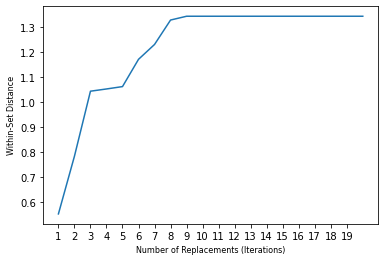

In [25]:
plt.plot(range(1,len(dists_per_iteration)+1),dists_per_iteration)
plt.xticks(np.arange(1, 20, 1))
plt.xlabel('Number of Replacements (Iterations)', fontsize=8)
plt.ylabel('Within-Set Distance', fontsize=8)
plt.show()